In [1]:
# sudo apt install default-jre
# pip install requests
# pip install tabulate
# pip install "colorama >= 0.3.8"
# pip install future
# pip install matplotlib
# pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [2]:
!java -version

openjdk version "11.0.20" 2023-07-18
OpenJDK Runtime Environment (build 11.0.20+8-post-Debian-1deb11u1)
OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Debian-1deb11u1, mixed mode, sharing)


In [3]:
# Load the H2O library
import numpy as np
import pandas as pd
import h2o
import seaborn as sns
from IPython.display import display

In [4]:
# Initialize h2o cluster
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 3, ip = "localhost", port = 54323)

Checking whether there is an H2O instance running at http://localhost:54323..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Debian-1deb11u1); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Debian-1deb11u1, mixed mode, sharing)
  Starting server from /opt/bitnami/python/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpptyyzwws
  JVM stdout: /tmp/tmpptyyzwws/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpptyyzwws/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_pv78ro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [5]:
dataset_csv = "smoking_driking_dataset_Ver01.csv"
data = h2o.import_file(dataset_csv, header = 1, sep =",")
print(str(data.shape[0]) + " x " + str(data.shape[1]))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
991346 x 24


In [6]:
display(data)

sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
Male,35,170,75,90,1,1,1,1,120,80,99,193,48,126,92,17.1,1,1,21,35,40,1,Y
Male,30,180,80,89,0.9,1.2,1,1,130,82,106,228,55,148,121,15.8,1,0.9,20,36,27,3,N
Male,40,165,75,91,1.2,1.5,1,1,120,70,98,136,41,74,104,15.8,1,0.9,47,32,68,1,N
Male,50,175,80,91,1.5,1.2,1,1,145,87,95,201,76,104,106,17.6,1,1.1,29,34,18,1,N
Male,50,165,60,80,1,1.2,1,1,138,82,101,199,61,117,104,13.8,1,0.8,19,12,25,1,N
Male,50,165,55,75,1.2,1.5,1,1,142,92,99,218,77,95,232,13.8,3,0.8,29,40,37,3,Y
Female,45,150,55,69,0.5,0.4,1,1,101,58,89,196,66,115,75,12.3,1,0.8,19,12,12,1,N
Male,35,175,65,84.2,1.2,1,1,1,132,80,94,185,58,107,101,14.4,1,0.8,18,18,35,3,Y
Male,55,170,75,84,1.2,0.9,1,1,145,85,104,217,56,141,100,15.1,1,0.8,32,23,26,1,Y
Male,40,175,75,82,1.5,1.5,1,1,132,105,100,195,60,118,83,13.9,1,0.9,21,38,16,2,Y


In [7]:
def count_percent(df, var):
    df_agg = df.group_by(var).count().get_frame()
    total = df_agg['nrow'].sum()
    df_agg['percentage'] = df_agg['nrow'] / total
    return df_agg

In [8]:
display(count_percent(data, 'DRK_YN'))

DRK_YN,nrow,percentage
N,495858,0.500187
Y,495488,0.499813


In [9]:
by_col = "age"
target_col = "DRK_YN"
agg_col = by_col + "_range"
num_quantile = 10
df_data = data[[by_col, target_col]]
df_data['target'] = (df_data[target_col] == 'Y').ifelse(1, 0)

prob = list(np.arange(1, num_quantile, 1)/num_quantile)
quantiles = df_data[by_col].quantile(prob = prob)
quantil_min = df_data[by_col].min()
quantil_max = df_data[by_col].max()
quantiles_pd = quantiles[1].as_data_frame()
quantiles_list = quantiles_pd.iloc[:, 0].to_list()
quantiles_list.append(quantil_min)
quantiles_list.append(quantil_max)
quantiles_list = list(set(quantiles_list))
quantiles_list.sort()

df_data[agg_col] = df_data[by_col].cut(quantiles_list, include_lowest = True)

df_agg = df_data.group_by(agg_col).count().min(by_col).max(by_col).sum('target').get_frame().as_data_frame()

total = df_agg['nrow'].sum()
df_agg = df_agg.rename(columns={'sum_target':'bad'})
df_agg['good'] = df_agg['nrow'] - df_agg['bad']
df_agg['percentage'] = df_agg['nrow'] / total
df_agg['bad_rate'] = df_agg['bad'] / df_agg['nrow']
df_agg['good_rate'] = df_agg['good'] / df_agg['nrow']
total_bad = df_agg['bad'].sum()
total_good = df_agg['good'].sum()
df_agg['perc_events'] = df_agg['bad'] / total_bad
df_agg['perc_non_events'] = df_agg['good'] / total_good
df_agg['woe'] = np.log(df_agg['perc_non_events'] / df_agg['perc_events'])
df_agg['iv'] = (df_agg['perc_non_events'] - df_agg['perc_events']) * df_agg['woe']
iv = df_agg['iv'].sum()
display(df_agg)

print('Information Value: ' + str(round(iv, 5)))

,age_range,nrow,min_age,max_age,bad,good,percentage,bad_rate,good_rate,perc_events,perc_non_events,woe,iv
0,"[20.0,30.0]",163941,20,30,108704,55237,0.165372,0.663068,0.336932,0.219388,0.111397,-0.677742,0.073190
1,"(30.0,35.0]",84726,35,35,56220,28506,0.085466,0.663551,0.336449,0.113464,0.057488,-0.679904,0.038058
2,"(35.0,40.0]",130385,40,40,78186,52199,0.131523,0.599655,0.400345,0.157796,0.105270,-0.404774,0.021261
3,"(40.0,45.0]",118355,45,45,66245,52110,0.119388,0.559714,0.440286,0.133696,0.105091,-0.240750,0.006887
4,"(45.0,50.0]",129434,50,50,64112,65322,0.130564,0.495326,0.504674,0.129392,0.131735,0.017951,0.000042
5,"(50.0,55.0]",111223,55,55,47984,63239,0.112194,0.431422,0.568578,0.096842,0.127534,0.275307,0.008450
6,"(55.0,60.0]",106063,60,60,38341,67722,0.106989,0.361493,0.638507,0.077380,0.136575,0.568145,0.033631
7,"(60.0,65.0]",52961,65,65,16272,36689,0.053423,0.307245,0.692755,0.032840,0.073991,0.812285,0.033426
8,"(65.0,85.0]",94258,70,85,19424,74834,0.095081,0.206073,0.793927,0.039202,0.150918,1.348016,0.150596


Information Value: 0.36554


In [10]:
train, valid = data.split_frame(ratios = [0.7], seed = 1234)

display(count_percent(train, 'DRK_YN'))

display(count_percent(valid, 'DRK_YN'))

DRK_YN,nrow,percentage
N,347100,0.50016
Y,346878,0.49984


DRK_YN,nrow,percentage
N,148758,0.500249
Y,148610,0.499751


In [11]:
y = 'DRK_YN'
x = list(data.columns)
x.remove(y)  #remove the response

In [12]:
# Import H2O GLM:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [13]:
model = H2OGeneralizedLinearEstimator(family = "binomial")
model.train(y = y, x = x, training_frame = train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1699563465891_2


GLM Model: summary
    family    link    regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 3.745E-4 )  24                            24                             4                       py_17_sid_9352

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18161199755844645
RMSE: 0.4261595916536978
LogLoss: 0.5427301647441274
AUC: 0.8026331114268583
AUCPR: 0.7901412154675567
Gini: 0.6052662228537167
Null degrees of freedom: 693977
Residual degrees of freedom: 693953
Null deviance: 962057.7171236364
Residual deviance: 754901.1045879977
AIC: 754951.1045879977

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34828097161278276
       N       Y       Error    Rate
-----  ------  ------  -------  -------------------
N      192692  154408  0.4449   (154408.0/347100.0)
Y      47061   299817  0.1357   (47061.0/346878.0)
Total  239753  454225  0.2903   (201469.0/693978.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348281     0.74851   265
max f2                       0.197698     0.851446  332
max f0point5                 0.570703     0.731129  171
max accuracy                 0.485052     0.72662   208
max precision                0.941357     0.940084  17
max recall                   0.00220374   1         399
max specificity              0.999271     0.999542  0
max absolute_mcc             0.442766     0.454212  225
max min_per_class_accuracy   0.492608     0.72603   204
max mean_per_class_accuracy  0.485052     0.726622  208
max tns                      0.999271     346941    0
max fns                      0.999271     345214    0
max fps                      0.00220374   347100    399
max tps                      0.00220374   346878    399
max tnr                      0.999271     0.999542  0
max fnr                      0.999271     0.995203  0
max fpr                      0.00220374   1         399
max tpr                      0.00220374   1         399

Gains/Lift Table: Avg response rate: 49.98 %, avg score: 49.98 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100003                   0.973204           1.8614    1.8614             0.930403         0.989212  0.930403                    0.989212            0.0186146       0.0186146                  86.1402   86.1402            0.0172231
2        0.0200006                   0.948051           1.8983    1.87985            0.948847         0.959803  0.939625                    0.974507            0.0189836       0.0375982                  89.8302   87.9852            0.0351839
3        0.030001                    0.930322           1.8761    1.8786             0.937752         0.93888   0.939001                    0.962632            0.0187616       0.0563599                  87.6104   87.8603            0.052701
4        0.0400013                   0.916379           1.85016   1.87149            0.924784         0.923198  0.935447                    0.952773            0.0185022     

In [14]:
# Eval performance:
valid_perf1 = model.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(round(valid_perf1.auc(), 5)))
print("Gini: " + str(round(valid_perf1.gini(), 5)))

AUC: 0.80224
Gini: 0.60447


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           82543   66215
Y           20177  128433


<Axes: xlabel='Prediction', ylabel='Original'>

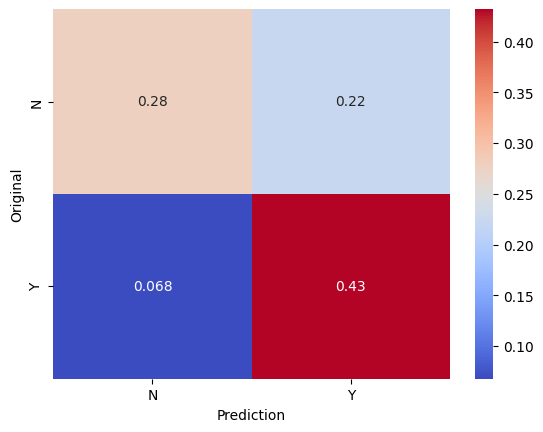

In [15]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = model.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [16]:
from h2o.estimators import H2ODeepLearningEstimator

In [17]:
# Initialize and train the DL estimator:
dl_model = H2ODeepLearningEstimator(hidden = [200, 100], epochs = 20.0, stopping_metric = "auc")
dl_model.train(x = x, y = y, training_frame = train)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1699563465891_5


Status of Neuron Layers: predicting DRK_YN, 2-class classification, bernoulli distribution, CrossEntropy loss, 25,502 weights/biases, 309.6 KB, 10,698,478 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight           weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  --------------------  ----------  --------------------  -------------------  -------------------  -------------------
    1        25       Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.050798383578314676  0.19741660356521606   0.0         -0.07026040756153015  0.44421637058258057  -0.5752126015134382  0.4019700288772583
    3        100      Rectifier  0.0        0.0   0.0   0.08948327934874468   0.10486823320388794   0.0         -0.0737635919454367   0.15067064762115479  0.09128070619619055  0.2789735794067383
    4        2        Softmax               0.0   0.0   0.008133187558214558  0.005064528435468674  0.0         -0.03572129577689338  0.43144309520721436  0.04073638426429656  0.21377378702163696

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1710379054556747
RMSE: 0.41356729253614183
LogLoss: 0.5137337313144018
Mean Per-Class Error: 0.2770641478773106
AUC: 0.82481990656104
AUCPR: 0.8262594945163201
Gini: 0.64963981312208

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35880479040318636
       N     Y     Error    Rate
-----  ----  ----  -------  ---------------
N      2900  2023  0.4109   (2023.0/4923.0)
Y      716   4284  0.1432   (716.0/5000.0)
Total  3616  6307  0.276    (2739.0/9923.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358805     0.757761  260
max f2                       0.123582     0.856478  349
max f0point5                 0.604897     0.761224  158
max accuracy                 0.504925     0.744936  200
max precision                0.998759     1         0
max recall                   0.0100392    1         397
max specificity              0.998759     1         0
max absolute_mcc             0.504925     0.490059  200
max min_per_class_accuracy   0.496439     0.744059  204
max mean_per_class_accuracy  0.504925     0.745009  200
max tns                      0.998759     4923      0
max fns                      0.998759     4991      0
max fps                      0.00316249   4923      399
max tps                      0.0100392    5000      397
max tnr                      0.998759     1         0
max fnr                      0.998759     0.9982    0
max fpr                      0.00316249   1         399
max tpr                      0.0100392    1         397

Gains/Lift Table: Avg response rate: 50.39 %, avg score: 49.08 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100776                   0.973391           1.92506   1.92506            0.97             0.984277   0.97                        0.984277            0.0194          0.0194                     92.5062   92.5062            0.0187906
2        0.0200544                   0.96052            1.92446   1.92476            0.969697         0.966631   0.969849                    0.975498   

In [18]:
# Eval performance:
valid_perf2 = dl_model.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(round(valid_perf2.auc(), 5)))
print("Gini: " + str(round(valid_perf2.gini(), 5)))

AUC: 0.821
Gini: 0.64201


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           87440   61318
Y           21423  127187


<Axes: xlabel='Prediction', ylabel='Original'>

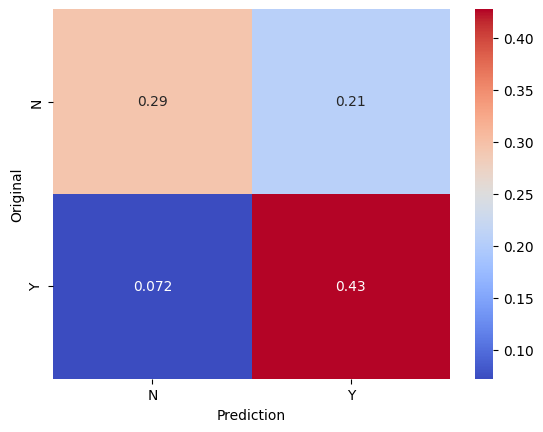

In [19]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = dl_model.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [20]:
from h2o.estimators import H2ODecisionTreeEstimator

In [21]:
model_tree = H2ODecisionTreeEstimator(max_depth = 7)
model_tree.train(x = x, y = y, training_frame = train)

dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODecisionTreeEstimator : Decision Tree
Model Key: DT_model_python_1699563465891_26

No summary for this model

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [22]:
# Eval performance:
valid_perf3 = model_tree.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(round(valid_perf3.auc(), 5)))
print("Gini: " + str(round(valid_perf3.gini(), 5)))

AUC: 0.6844
Gini: 0.36879


dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           97231   51527
Y           42328  106282


<Axes: xlabel='Prediction', ylabel='Original'>

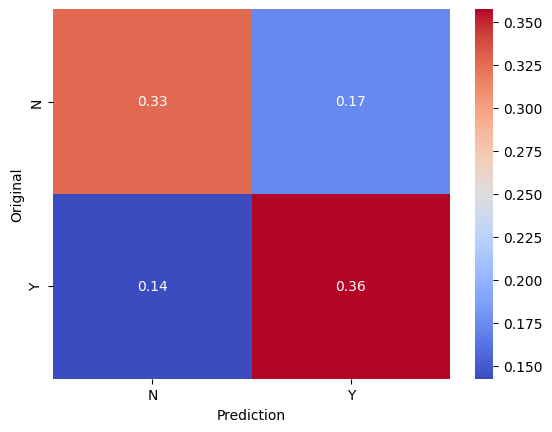

In [23]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = model_tree.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [24]:
from h2o.estimators import H2OGradientBoostingEstimator

In [25]:
model_gbm = H2OGradientBoostingEstimator(nfolds = 5, ntrees = 100, max_depth = 7, stopping_rounds = 5, stopping_metric = "AUC")
model_gbm.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |

/opt/bitnami/python/lib/python3.11/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1699563465891_28


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         154275                 7            7            7             81            128           118.27

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.16863170701986008
RMSE: 0.41064791125714994
LogLoss: 0.5057681196160003
Mean Per-Class Error: 0.2688883006064671
AUC: 0.8295815337792323
AUCPR: 0.831041283791346
Gini: 0.6591630675584645

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38537513318477773
       N       Y       Error    Rate
-----  ------  ------  -------  -------------------
N      210874  136226  0.3925   (136226.0/347100.0)
Y      50404   296474  0.1453   (50404.0/346878.0)
Total  261278  432700  0.2689   (186630.0/693978.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385375     0.760601  250
max f2                       0.170955     0.856118  338
max f0point5                 0.612956     0.758347  155
max accuracy                 0.497316     0.746008  203
max precision                0.980907     0.990724  0
max recall                   0.0211488    1         399
max specificity              0.980907     0.999986  0
max absolute_mcc             0.497316     0.492116  203
max min_per_class_accuracy   0.507409     0.745493  199
max mean_per_class_accuracy  0.497316     0.746011  203
max tns                      0.980907     347095    0
max fns                      0.980907     346344    0
max fps                      0.0211488    347100    399
max tps                      0.0211488    346878    399
max tnr                      0.980907     0.999986  0
max fnr                      0.980907     0.998461  0
max fpr                      0.0211488    1         399
max tpr                      0.0211488    1         399

Gains/Lift Table: Avg response rate: 49.98 %, avg score: 49.98 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100003                   0.963732           1.9796    1.9796             0.989481         0.970931   0.989481                    0.970931            0.0197966       0.0197966                  97.9596   97.9596            0.0195863
2        0.0200006                   0.953817           1.97124   1.97542            0.985303         0.958632   0.987392                    0.964781            0.019713        0.0395096                  97.1236   97.5416            0.0390054
3        0.030001                    0.944818           1.95163   1.96749            0.975504         0.949222   0.983429                    0.959595            0.0195169       0.0590265                  95.1633   96.7488            0.0580326
4        0.0400013                   0.936229           1.93549   1.95949            0.967435         0.940527   0.979431                    0.954828            0.0193555       0.078382                   93.5489   95.9489            0.076737
5        0.0500001                   0.927517           1.92625   1.95284            0.962819         0.9

In [26]:
# Eval performance:
valid_perf4 = model_gbm.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(round(valid_perf4.auc(), 5)))
print("Gini: " + str(round(valid_perf4.gini(), 5)))

AUC: 0.82239
Gini: 0.64477


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           89253   59505
Y           22390  126220


<Axes: xlabel='Prediction', ylabel='Original'>

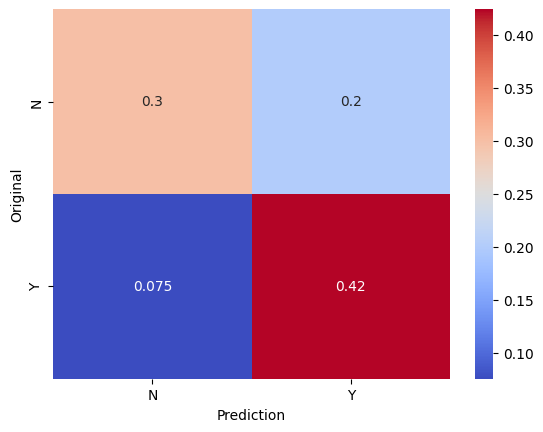

In [27]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = model_gbm.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [28]:
# Shutdown cluster
h2o.cluster().shutdown()

H2O session _sid_9352 closed.
